## Imports

In [60]:
%load_ext autoreload
%autoreload 2

import os
import mat73
import numpy as np
import torch
import matplotlib.pyplot as plt

import fibernet
import pr.pim_pr as pim
from utils.utils import crop_img

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load model, extract matrix, load dataset

In [2]:
model = torch.load('C:/Users/saucourt/Coding/fibernet_analysis/training_analysis/trained_models/model2.pth')
matrix = model.linear_list[0].layer._parameters['weight'].cpu().detach().numpy()
bias = model.bias.cpu().detach().numpy()
phases_dim = model.phases_dim
intens_dim = model.intens_dim
intens_shape = model.intens_shape

In [3]:
path = "C:\\Users\\saucourt\\Datasets"
file = "data_base_02_03_0deg.mat"
data = mat73.loadmat(os.path.join(path, file))

CP = np.reshape(np.array(data['CP']), newshape=(-1, 128, 128))
vec = np.reshape(np.array(data['vecteur_36']) , newshape=(-1, 36))

In [80]:
NN = CP.shape[0]
As = np.zeros(shape=(NN, phases_dim), dtype=complex)
Bs = np.zeros(shape=(NN, intens_dim), dtype=float)

amp = fibernet.dataset._utils.make_bellshaped_plane_2d(vec[0].reshape((6,6)))
amp = amp.flatten()

for i in range(NN):
    phi = vec[i]
    phi = amp * np.exp(1j * phi)
    # phi = np.exp(1j * phi)
    phi = np.delete(phi, [0, 5, 30, 35])

    img = crop_img(CP[i], crop=3)
    img = img.flatten().astype('float')
    As[i,:] = phi
    Bs[i,:] = np.sqrt(img)

## Run PIM-PR attempts from model-learnt transfer matrix

Quality: 0.15031962631752865
Quality: 0.4899950150093222
Quality: 0.810849946945003
Quality: 0.9675485154654666
Quality: 0.9866557183788935
Quality: 0.9950470518927306
Quality: 0.9987180340599844
Quality: 0.9996555870158838


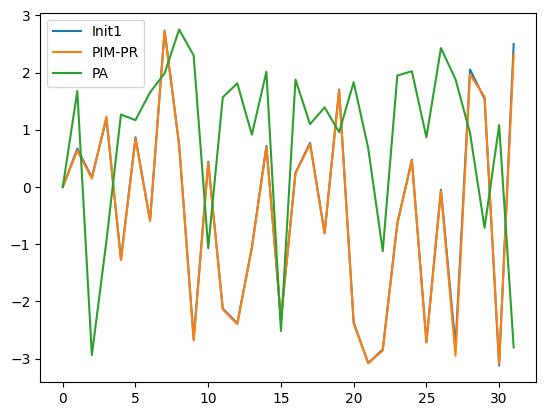

In [114]:
# i = np.random.randint(0, NN)
i = 50
x0 = As[i,:]
b0 = Bs[i,:]

amp = fibernet.dataset._utils.make_bellshaped_plane_2d(vec[0].reshape((6,6)))
amp = amp.flatten()
amp = np.delete(amp, [0, 5, 30, 35])

xc = amp * np.exp(1j * 2*np.pi * np.zeros_like(amp))
x_opt = pim.pim_retrieval_svd(x0, xc, matrix, max_Q=0.999)
x_est = pim.internal_pr_svd(b0, xc, matrix)

fig = plt.figure()
plt.plot(np.angle(np.exp(1j * (np.angle(x0) - np.angle(x0[0])))), label='Init')
plt.plot(np.angle(np.exp(1j * (np.angle(x_opt) - np.angle(x_opt[0])))), label='PIM-PR')
plt.plot(np.angle(np.exp(1j * (np.angle(x_est) - np.angle(x_est[0])))), label='PA')
plt.legend()